<a href="https://colab.research.google.com/github/Chetan-Sagathiya/Twitter_Sentiment_Analysis/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [12]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [13]:
data = pd.read_csv("/content/drive/MyDrive/ml_datasets/twitter_sentiment_dataset/train.csv")
data

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


0    29720
1     2242
Name: label, dtype: int64


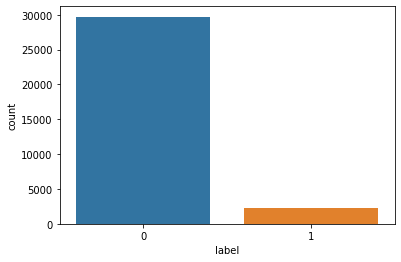

In [14]:
print(data['label'].value_counts())
sns.countplot(data = data, x= 'label')
plt.show()

In [15]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [16]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [17]:
wordnet = WordNetLemmatizer()
def clean_tweets(df):
  tempArr = []
  for lines in df:
    tweet = re.sub(r"[^a-zA-Z]+", ' ', lines)
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [wordnet.lemmatize(word) for word in tweet if not word in set(stopwords.words('english'))]
    if len(tweet) == 0:
      # if all the words im tweet are stopwords then
      tweet = 'I'
    else:
      tweet = ' '.join(tweet)
    tweet
    tempArr.append(tweet)
  return tempArr

In [18]:
cleaned_tweets = clean_tweets(data['tweet']) 
cleaned_tweets = pd.DataFrame(cleaned_tweets, columns = ['cleaned_tweets'])
cleaned_tweets

,cleaned_tweets
0,user father dysfunctional selfish drag kid dys...
1,user user thanks lyft credit use cause offer w...
2,bihday majesty
3,model love u take u time ur
4,factsguide society motivation
...,...
31957,ate user isz youuu
31958,see nina turner airwave trying wrap mantle gen...
31959,listening sad song monday morning otw work sad
31960,user sikh temple vandalised calgary wso condem...


In [19]:
data = pd.concat([data, cleaned_tweets], axis=1)
data.head()

,id,label,tweet,cleaned_tweets
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drag kid dys...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks lyft credit use cause offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society motivation


In [20]:
def get_vec(tweet):
  vec = nlp(tweet).vector
  return vec

In [21]:
data['vector'] = data['cleaned_tweets'].apply(lambda x: get_vec(x))
data.head()

,id,label,tweet,cleaned_tweets,vector
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drag kid dys...,"[0.4842372, -0.06366028, -1.8760673, 1.5139647..."
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks lyft credit use cause offer w...,"[0.25390026, 0.040692586, -0.7003227, 1.487928..."
2,3,0,bihday your majesty,bihday majesty,"[1.5038044, -3.6027033, 0.57702637, 1.0233208,..."
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur,"[0.50754863, -1.1472391, 0.3886793, -0.3016174..."
4,5,0,factsguide: society now #motivation,factsguide society motivation,"[1.001973, -1.840333, -1.8968383, 0.4452219, 0..."


In [23]:
X = data['vector'].to_numpy()
X = X.reshape(-1,1)
X.shape

(31962, 1)

In [24]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 96)
X.shape

(31962, 96)

In [25]:
y = data['label']
y.shape

(31962,)

In [26]:
X = pd.DataFrame(data=X)
print(X.shape)
X.head()

(31962, 96)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0.484237,-0.063660,-1.876067,1.513965,0.903164,1.085821,-1.039162,0.685801,0.748216,1.514805,1.501953,-0.042835,2.132077,-1.908023,-0.976331,-1.245049,-0.208043,0.849614,-0.609904,-1.237363,1.884879,-0.274585,-0.733649,0.287821,-1.256699,-0.696546,-0.104079,-1.575460,2.648796,-2.156358,1.189674,-0.837486,0.880723,-0.984216,-0.601586,-1.802475,3.335490,-2.297085,-0.844811,0.936667,...,1.093273,0.847932,-0.181751,-0.371594,-0.102845,-1.424522,0.279691,0.633065,1.544120,0.069165,0.629969,-0.999094,0.000336,2.163558,-0.339158,0.529853,0.906810,-0.103161,-1.857458,-0.945921,1.038766,-1.668507,-1.041669,0.459283,1.966843,-2.309974,-0.842470,-0.916354,1.212302,1.671487,-0.094677,-1.003883,-0.850711,0.440807,1.260222,1.310729,-0.524814,1.391378,0.542819,0.759497
1,0.253900,0.040693,-0.700323,1.487928,1.369673,0.700741,-0.847729,1.377118,0.469435,2.750267,0.798906,-0.592209,0.675735,-1.465937,-1.017152,-1.327133,0.234497,2.136158,-0.133456,-0.765450,1.911342,0.194763,-1.044708,-0.573287,-0.588544,-0.607044,-1.777504,-1.214199,1.847115,-1.140393,0.846537,-0.788540,1.279718,-0.867794,-0.339754,-0.613724,2.788058,-0.272200,-1.189595,0.476553,...,0.971159,0.449943,-0.181763,0.743806,1.760420,-0.639095,-1.182919,0.026045,0.462989,-0.077112,-0.053873,-1.242142,0.030350,1.308936,0.099558,1.330681,0.831325,0.222719,-2.118773,-1.145565,0.221516,-1.330549,0.203291,0.395083,1.080643,-1.764443,-1.766278,-0.327917,1.394914,1.527128,-1.392845,-1.240809,0.307651,0.862424,-0.088787,-0.353965,-1.440317,1.769964,1.779546,0.251972
2,1.503804,-3.602703,0.577026,1.023321,1.312655,3.078755,0.407834,1.583958,0.624124,-0.083586,4.548596,-0.737282,0.768121,-1.405696,0.248144,-0.062052,-0.845322,1.245253,-1.559315,-2.004710,-1.010197,-2.827828,0.942636,-0.228079,-0.540501,0.756521,-0.172178,-2.936674,2.462239,-1.297515,-0.349874,-1.239088,1.586554,-0.468575,1.991300,-2.019989,1.461250,-2.318907,-3.426884,0.645418,...,-0.500691,1.682466,1.283875,-0.900630,-0.039470,-0.423332,1.872681,-2.129486,0.311545,0.068233,-1.109609,-1.609189,0.155175,0.448419,0.262575,-0.790192,-0.637425,3.321697,-0.080048,-0.623244,1.319050,-2.564081,0.396766,0.909904,1.324104,-1.896039,-1.667509,-2.310678,4.671798,3.146747,-1.059531,-1.318092,1.013545,-0.927031,1.800370,-0.700358,-0.473103,2.870922,0.815842,0.595437
3,0.507549,-1.147239,0.388679,-0.301617,0.788179,0.067050,0.327527,1.762617,2.388988,1.953847,0.503259,0.821385,1.493097,-0.517032,-0.165637,-1.265650,-0.976586,0.599773,-0.433125,-2.048031,0.745509,-0.243487,-0.625436,-1.535937,-1.290078,-1.080523,0.036522,-1.361165,1.095034,-1.410925,1.881493,0.479683,0.369884,-0.220644,-0.021483,-0.634801,0.382186,-0.987853,-0.854619,-0.329107,...,2.136140,0.851381,-0.641524,0.157923,1.635191,-1.081926,-0.348470,0.730940,1.052075,-1.157489,0.695257,-0.231434,-1.107243,1.200682,-0.771153,1.065213,0.829353,0.470906,-1.752169,-0.702317,0.538821,0.183864,0.278136,-0.117674,0.853565,-0.904220,-1.696985,0.820874,1.222715,1.200499,-0.343116,-0.403862,-0.491196,-1.004862,0.314817,0.662512,-1.125968,2.380071,1.260137,0.957842
4,1.001973,-1.840333,-1.896838,0.445222,0.530917,0.248871,-1.043502,1.067319,0.351001,2.008231,0.449290,0.623015,0.462105,-1.521017,0.000500,-1.888612,0.198219,2.171026,-1.855737,-1.644413,2.049910,-0.306552,-0.821784,0.439966,-0.952529,-2.349629,1.168190,-1.456210,2.586136,-1.665002,0.147144,-0.651514,-0.066868,-0.703335,-0.507707,-1.507782,1.458941,-1.491042,-2.133775,0.083694,...,1.026536,1.757607,0.397265,1.461779,1.546709,-1.115306,-1.024439,1.358513,1.125635,1.052625,-1.629033,-2.371388,-0.290223,1.357499,-0.256757,-0.088839,2.740509,1.779910,-2.129094,0.546521,2.363982,-2.131836,0.221449,-0.358665,2.646334,-1.843588,-1.676504,-0.042541,0.624714,1.292201,-0.078560,-0.472756,-0.127975,0.65

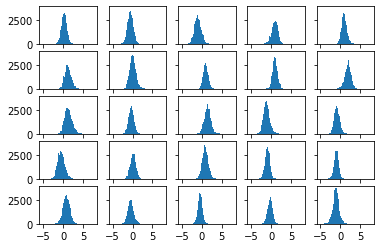

In [30]:
fig, axes = plt.subplots(5,5, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.hist(X[i], 50)

plt.show()

## Data seems to follow Gaussian Distribution so we can use GaussianNB

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [32]:
X_train.shape, X_test.shape

((25569, 96), (6393, 96))

In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [182]:
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

In [183]:
clf = GaussianNB()
tuning = GridSearchCV(clf, param_grid, cv=5, verbose=2, n_jobs=-1)

In [184]:
tuning.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.579...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [185]:
tuning.best_estimator_

GaussianNB(priors=None, var_smoothing=1.0)

In [186]:
tuning.best_score_

0.9172433774942078

In [187]:
nb_clf = GaussianNB(var_smoothing=1).fit(X_train, y_train)

In [188]:
y_predicted = nb_clf.predict(X_test)

In [189]:
accuracy_score(y_test, y_predicted)

0.9233536680744564

In [190]:
confusion_matrix(y_test, y_predicted)

array([[5858,  127],
       [ 363,   45]])

In [191]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5985
           1       0.26      0.11      0.16       408

    accuracy                           0.92      6393
   macro avg       0.60      0.54      0.56      6393
weighted avg       0.90      0.92      0.91      6393



In [112]:
file_name = "gaussian_nb.pkl"
with open(file_name, 'wb') as file:  
    pickle.dump(nb_clf, file)

In [192]:
## using logistic regression

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [54]:
forest_clf = RandomForestClassifier()
forest_params_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                     'min_samples_split': [x for x in range(2,5)],
                     'max_leaf_nodes': [2, 3, 4, None],
                     'min_samples_leaf': [x for x in range(1,5)],
                     'n_estimators' : [50,70,90, 100, 120, 130, 150, 160, 170, 190],
                     }

In [55]:
forest_tuning = RandomizedSearchCV(forest_clf, forest_params_grid, cv=5, verbose=2, n_jobs=-1, n_iter=300)

In [56]:
forest_tuning.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 66.8min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 104.7min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 152.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 156.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [57]:
forest_tuning.best_score_

0.9387539457306714

In [59]:
forest_tuning.best_params_

{'max_depth': 60,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 90}

In [60]:
forest_clf = RandomForestClassifier(max_depth = 60, max_leaf_nodes = None, min_samples_leaf = 1, min_samples_split = 3, n_estimators =90).fit(X_train, y_train)

In [61]:
y_predicted = forest_clf.predict(X_test)

In [62]:
accuracy_score(y_test, y_predicted)

0.9446269357109338

In [63]:
confusion_matrix(y_test, y_predicted)

array([[5985,    0],
       [ 354,   54]])

In [64]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5985
           1       1.00      0.13      0.23       408

    accuracy                           0.94      6393
   macro avg       0.97      0.57      0.60      6393
weighted avg       0.95      0.94      0.92      6393



In [67]:
file_name_pkl = "random_forest.pkl"
with open(file_name_pkl, 'wb') as file:  
    pickle.dump(forest_clf, file)